In [1]:
import copy
import sys
import time
sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from torch.optim import Adagrad, Adam, RMSprop, SGD
from torch.optim.lr_scheduler import ExponentialLR

from gglm.glm.holi import MMDGLM
from gglm.glm.torchglm import TorchGLM
from sptr.sptr import SpikeTrain
from gglm.metrics import bernoulli_log_likelihood_poisson_process
from kernel.fun import KernelFun
from kernel.values import KernelBasisValues

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

In [2]:
path = "/home/diego/python/generative-glm/cool_stuff/human_ctx.h5"
f = loadmat('./human_ctx.h5')

arg_spikes = (np.array(f['MC']['spikeTimes'][0][0], dtype=int), np.array(f['MC']['spikeIndices'][0][0], dtype=int) - 1)

dt = 1
t = np.arange(0, 10000, dt)
mask_spikes = np.zeros((len(t), 10), dtype=bool)
mask_spikes[arg_spikes] = True

n_train = 10
mask_spikes_train = mask_spikes[:, :n_train]
n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)
# mask_spikes_val = mask_spikes[:, n_train:]
# fr_val = np.mean(np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000)

st_train = SpikeTrain(t, mask_spikes_train)
isi_train = st_train.isi_distribution()
mean_isi_train = np.mean(isi_train)

# st_val = SpikeTrain(t, mask_spikes_val)
# isi_val = st_val.isi_distribution()
# mean_isi_val = np.mean(isi_val)

In [3]:
def fun_metrics_ml(model, t, mask_spikes, X, n_batch_fr=None):
    T = st_train.t[-1] - st_train.t[0] + st_train.t[1]
    u_fr, r_fr, mask_spikes_fr = model.sample(st_train.t, shape=(n_batch_fr,))
    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr = np.mean(fr)
    return dict(mu_fr=mu_fr)

### ML

720.8850116928763


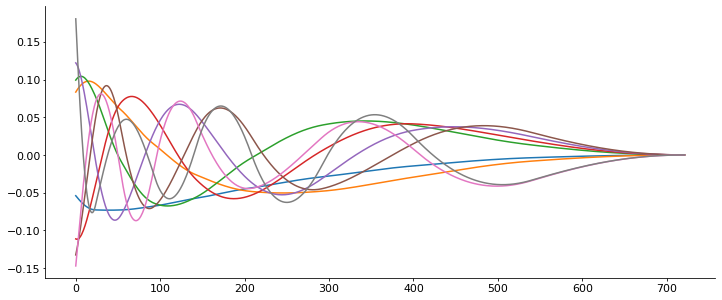

In [4]:
def raised_cosine(t, b, c, dc, a=1e0):
    basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
    basis = basis / np.sqrt(np.sum(basis**2, 0))
    u, s, v = np.linalg.svd(basis)
    basis = u[:, :basis.shape[1]]
    return basis

n = 8
last_peak = 400
b = last_peak / 5
peak0 = 0

yrnge = np.log(np.array([0, last_peak]) + b)
db = np.diff(yrnge) / (n - 1)
ctrs = np.arange(yrnge[0], yrnge[1] + db, db)
mxt = np.exp(yrnge[1] + 2 * db) - b # max time bin
print(mxt[-1])
t_ker = np.arange(0, mxt[-1] + dt, dt)

basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t_ker, basis)

In [5]:
coefs = np.zeros(basis.shape[1])
eta0 = KernelBasisValues(basis.copy(), [0, basis.shape[0]], 1, coefs=coefs)

lr = 1e-1
num_epochs = 200
metrics_kwargs = dict(n_batch_fr=60)
n_metrics = 10

glm = TorchGLM(u0=-5, eta=eta0.copy())
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=fun_metrics_ml, metrics_kwargs=metrics_kwargs, 
                                n_metrics=n_metrics)
loss_ml = np.array(loss_ml)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_train = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk_train
ll_normed_train = (-loss_ml - (-nll_pois_proc_train)) / np.log(2) / n_spk_train

_, r_train_dc_ml = glm.sample_conditioned(st_train.t, st_train.mask)
r_train_dc_ml = np.mean(r_train_dc_ml, 1)
# _, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(st_train.mask.shape[1],))
_, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(200,))
st_fr_ml = SpikeTrain(st_train.t, mask_spikes_fr_ml)
isi_fr_ml = st_fr_ml.isi_distribution()
mean_isi_fr_ml = np.mean(isi_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)

 epoch 199 of 200 nll 812.8286

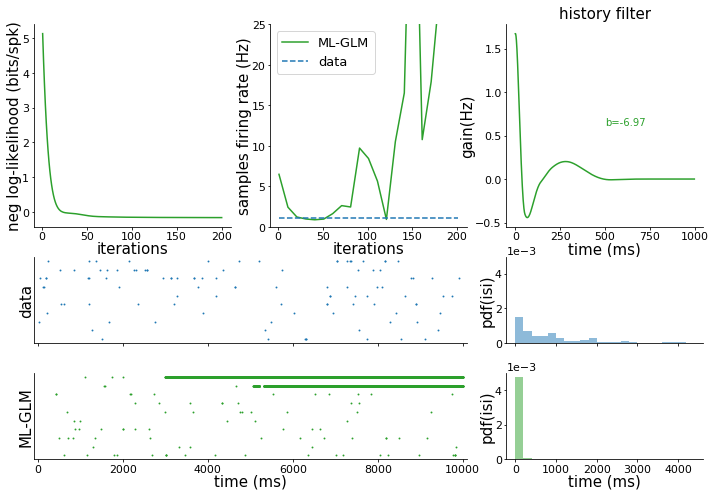

In [6]:
for key, val in metrics_ml.items():
    metrics_ml[key] = np.array(val)

ms = 0.9
arg_blow = np.where(np.sum(mask_spikes_fr_ml, 0) > 200)[0][:2]
mask = st_fr_ml.mask[:, np.random.choice(st_fr_ml.mask.shape[1], size=8, replace=False)]
mask = np.concatenate((mask, st_fr_ml.mask[:, arg_blow]), axis=1)
mask = mask[:, np.random.choice(10, size=10, replace=False)]
st_fr_ml_plot = SpikeTrain(st_fr_ml.t, mask)
    
r1 = 2
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=r1)
ax2 = plt.subplot2grid((4, 3), (0, 1), rowspan=r1)
ax3 = plt.subplot2grid((4, 3), (0, 2), rowspan=r1)
ax4 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax5 = plt.subplot2grid((4, 3), (2, 2), colspan=1)
ax6 = plt.subplot2grid((4, 3), (3, 0), colspan=2, sharex=ax4)
ax7 = plt.subplot2grid((4, 3), (3, 2), colspan=1, sharex=ax5, sharey=ax5)

ax1.plot(iterations_ml, nll_normed_train, color=palette['ml'])
# ax1.plot(iterations_ml, metrics_ml['nll_val'], color=palette['ml'])
myplt.set_labels(ax1, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

ax2.plot(iterations_ml[::n_metrics], metrics_ml['mu_fr'], '-', label='ML-GLM', color=palette['ml'])
ax2.plot([1, num_epochs + 1], [fr_train, fr_train], '--', color=palette['d'], label='data')
ax2.set_ylim(0, 25)
myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
ax2.legend()

glm.eta.plot(t=np.arange(0, 1000, 1), ax=ax3, exp_values=False, color=palette['ml'])
myplt.set_labels(ax3, xlabel='time (ms)', ylabel='gain(Hz)', title='history filter')
ax3.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax3.transAxes)
# ax3.set_ylim(-0.4, 0.2)

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3)
st_train.plot(ax=ax4, ms=ms, color=palette['d'])
# st_val.plot(ax=ax4, ms=0.7, color=palette['d'])
ax4.tick_params(axis='both', labelbottom=False, labelleft=False)
ax4.set_yticks([])
# ax4.set_xlabel(None)
ax4.set_ylabel('data')

bins = np.arange(0, 4600, 200)
ax5.hist(isi_train, density=True, color=palette['d'], label='data', alpha=0.5, bins=bins)
ax5.set_ylabel('pdf(isi)')
ax5.tick_params(axis='both', labelbottom=False)

# st_fr_ml.plot(ax=ax5, ms=0.7, color=palette['ml'])
st_fr_ml_plot.plot(ax=ax6, ms=ms, color=palette['ml'])
myplt.set_labels(ax6, xlabel='time (ms)', ylabel='ML-GLM')
ax6.set_yticks([])

ax7.hist(isi_fr_ml, density=True, color=palette['ml'], label='ML-GLM', alpha=0.5, bins=bins)
myplt.set_labels(ax7, xlabel='time (ms)', ylabel='pdf(isi)')
ax7.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

fig.subplots_adjust(hspace=0.35)
# fig.savefig('/home/diego/Dropbox/generative_glm/figures/human_ctx/human_ctx_ML.pdf', transparent=True)

### MMD

In [9]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    T_train = t[-1] - t[0] + t[1]
    mu_fr = torch.mean(torch.sum(mask_spikes_fr.double(), 0)) / T_train * 1000
    return dict(mu_fr=mu_fr)

In [10]:
def kerneln_expn(t, mask_spikes1, mask_spikes2):
    n_spk1 = torch.sum(mask_spikes1, 0).double()
    n_spk2 = torch.sum(mask_spikes2, 0).double()
    gramian = torch.exp(-(n_spk1[:, None] - n_spk2[None, :])**2 / sd2)
    return gramian

def phi_sum(t, mask_spikes):
    return torch.sum(mask_spikes, 0).double()[None, :]

dic_ker_strings = {'phi_sum': "sum_s * sum_s'", 'kerneln_expn': "exp(-sum((s-s')^2)/sd^2)"}
dic_ker_name = {'phi_sum': "sum_product", 'kerneln_expn': "gaussian"}

In [27]:
phi, kernel, lam_mmd, lr, clip = phi_sum, None, 1e0, 1e-2, 1e0 

sd2 = 1e0

beta0, beta1 = 0, 0
n_batch_fr = 100
biased = False
num_epochs = 400

time0 = time.time()
u00 = glm.u0
eta0 = glm.eta.copy()
# eta0_scaled = glm.eta.copy()
# eta0_scaled.coefs = eta0_scaled.coefs * 0.1

mmdglm = MMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                                log_likelihood=True, 
                                              n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, num_epochs=num_epochs, 
                                              verbose=True, metrics=fun_metrics_mmd, n_metrics=1)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_train = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(st_train.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)
r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000

time1 = time.time()
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 399 of 400 loss -13461.7509516053
 took 469.6301257610321 seconds 7.827168762683868 minutes


In [ ]:
(loss_mmd - nll_train)

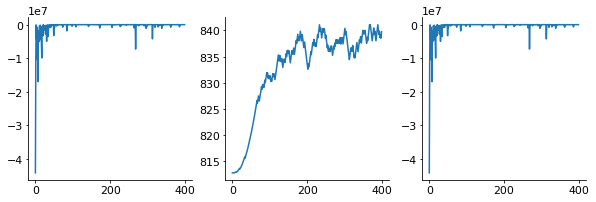

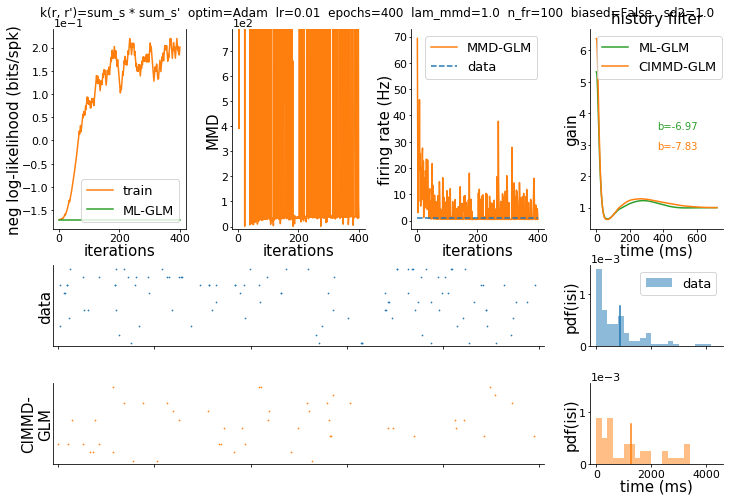

In [29]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

if phi is not None:
    ker_name = phi.__name__
else:
    ker_name = kernel.__name__
    
title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
     + '  epochs=' + str(num_epochs) + \
       '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased) + '   sd2=' + str(sd2)
    
r1, r2 = 2, 1
ncols = 4

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
ax1.plot(loss_mmd)
ax2.plot(nll_train)
ax3.plot(loss_mmd - nll_train)
# ax3.set_ylim(0, 1e4)

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
fig = plt.figure(figsize=(12, 8))
fig.suptitle(title, fontsize=12, y=0.92)
ax00 = plt.subplot2grid((r1 + 2*r2, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((r1 + 2*r2, ncols), (0, 1), rowspan=r1, sharex=ax00)
ax02 = plt.subplot2grid((r1 + 2*r2, ncols), (0, 2), rowspan=r1, sharex=ax00)
ax03 = plt.subplot2grid((r1 + 2*r2, ncols), (0, 3), rowspan=r1)
ax10 = plt.subplot2grid((r1 + 2*r2, ncols), (r1, 0), colspan=ncols - 1)
ax11 = plt.subplot2grid((r1 + 2*r2, ncols), (r1, ncols - 1), colspan=1)
ax20 = plt.subplot2grid((r1 + 2*r2, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
ax21 = plt.subplot2grid((r1 + 2*r2, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
# ax30 = plt.subplot2grid((r1 + 3*r2, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)

ax00.plot(iterations_mmd, nll_normed_train, '-', label='train', color=palette['mmd'])
ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train[0], nll_normed_train[0]], '-', 
          label='ML-GLM', color=palette['ml'])
ax00.spines['right'].set_visible(True)
ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax00.legend()
myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')
# ax00.plot(iterations_mmd[0], nll_train[0], '-.', label='val', color=palette['mmd'])
# ax00twin = ax00.twinx()
# ax00twin.plot(iterations_mmd, metrics_mmd['nll_val'], '-.', label='val', color=palette['mmd'])
# ax00twin.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax01.plot(iterations_mmd, metrics_mmd['mmd'], label='CIMMD-GLM', color=palette['mmd'])
ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
yf = np.mean(metrics_mmd['mmd'][-10:] * 2)
ax01.set_ylim(-yf*1e-2, yf)
myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

ax02.plot(iterations_mmd, metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
# ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
ax02.legend()

glm.eta.plot(t=t_ker, ax=ax03, exp_values=True, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=True, label='CIMMD-GLM', color=palette['mmd'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
ax03.legend()

bins = np.arange(0, 4600, 200)
ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('CIMMD-\nGLM')

ax30.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

# fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(hspace=0.45, wspace=0.35)

fig_name = 'mmd_' + dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

import os
list_files = os.listdir('/home/diego/Dropbox/generative_glm/figures/human_ctx/')

ii = 1
while fig_name + '_' + str(ii) + '.pdf' in list_files:
    ii += 1
fig_name += '_' + str(ii) + '.pdf'

fig.savefig('/home/diego/Dropbox/generative_glm/figures/human_ctx/' + fig_name, transparent=True)